In [94]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Preanalysis

The data set consists of headshots of 28 celebrities. There are several potential problems:

1) one's hairstyle or hair color is sometimes different in different pictures. Sometimes a person wearing sunglasses, which covers part of her or his face.


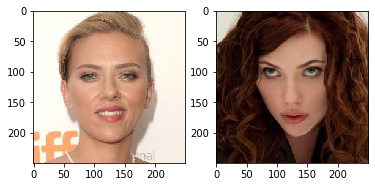

In [16]:
path = 'C:/Users/Piotr Grabysz/Documents/GSN data/dnn2020-1/train/'
img1 = mpimg.imread(path + '0424060/106.jpg')
img2 = mpimg.imread(path + '0424060/129.jpg')

plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)

2) some of the pictures are taken from movies, where a person might have strong makeup, 
or just look unusual. At picture below, without knowing the context (it's, seeing Star Wars)
it is impossible to know which actress is this. There are pictures, which also seem to be taken from some movie,
where there are harsh shadows on actor's face, making it difficult to recognize as well.

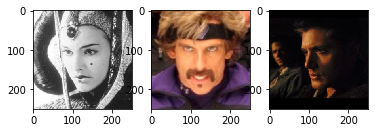

In [19]:
img1 = mpimg.imread(path + '0000204/270.jpg')
img2 = mpimg.imread(path + '0001774/172.jpg')
img3 = mpimg.imread(path + '0010075/133.jpg')

plt.subplot(1,3,1)
plt.imshow(img1)
plt.subplot(1,3,2)
plt.imshow(img2)
plt.subplot(1,3,3)
plt.imshow(img3)

3) different pictures are taken from different angles, so the network has to learn different parts
of a face of one person.

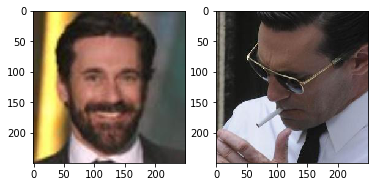

In [18]:
img1 = mpimg.imread(path + '0358316/154.jpg')
img2 = mpimg.imread(path + '0358316/495.jpg')

plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)

4) some pictures have very poor resolution, containing much less information about the subject.

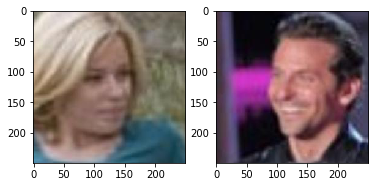

In [20]:
img1 = mpimg.imread(path + '0006969/163.jpg')
img2 = mpimg.imread(path + '0177896/262.jpg')

plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)

5) it happens that there is a second person on the picture, or even that the picture is incorrectly labaled. The pictures below are in Natalie Portman category.

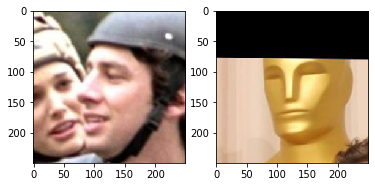

In [21]:
img1 = mpimg.imread(path + '0000204/174.jpg')
img2 = mpimg.imread(path + '0000204/286.jpg')

plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)

Having said that, there is a lot of very similar pictures in every category. Assuming that there is
around of 10% of difficult pictures in every category, I would suggest that the clasiffier should reach
90% accuracy, although as it can be seen later, it turns out that it is too optimistic guess. I would also
expect that accuracy depends on particular class. For example class 0000204, that is Natalie Portman, contains
many pictures which vary a lot (to my eye), so I would expect this class to have lower accuracy than others.
This might be verified via confusion matrix.

## Implementation

In both networks, one with and without batch normalization I used 4 convolutional layers and 2 fully connected layers. It is often said that initial convolutional layers learn basic representation,  like horizontal or vertical lines, while later layers learn more abstract concepts. This is a reason why I use small 3x3 filter in first layer, than I used 5x5 filters and 7x7 at the last layer. I use stride 1x1 and no padding in every layer. There is no reason why I used this particular number of filters. I just thought that this database is too small to use more.

In the case of network with batch normalization, I set biases of every layer but last to False (I didn't use batch normalization only after the last layer).

In [51]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [87]:
train_path = 'C:/Users/Piotr Grabysz/Documents/GSN data/projekt 1/train'
train_dataset = torchvision.datasets.ImageFolder(
        root=train_path,
        transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
)
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=True
    )

test_path = 'C:/Users/Piotr Grabysz/Documents/GSN data/projekt 1/test/'
test_dataset = torchvision.datasets.ImageFolder(
        root=test_path,
        transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=99,
        num_workers=0,
        shuffle=True
    )

Below I define network without batch normalization:

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 7)
        
        self.fc1 = nn.Linear(32 * 11 * 11, 1000)
        self.fc2 = nn.Linear(1000, 28)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
                
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = x.view(-1, 32*11*11)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()

In the next cells I define batch normalization layers (1d and 2d) and I construct the networks with these layers. I initialize all gammas (the term which we multiply) as 1 and all betas (the term which we add) as 0. In fact, this a kind of initialiaztion I found in the implementation of BatchNorm in pytorch. 

In [52]:
import sys

class BatchNorm1D(nn.Module):
    def reset_parameters(self):
        self.beta = torch.nn.Parameter(torch.zeros(self.n_nodes))
        self.gamma = torch.nn.Parameter(torch.ones(self.n_nodes))
        
    def __init__(self, n_nodes):
        super().__init__()
        self.n_nodes = n_nodes
        self.beta = torch.nn.Parameter(torch.Tensor(n_nodes))
        self.gamma = torch.nn.Parameter(torch.Tensor(n_nodes))
        self.epsilon = 10e-5
        self.reset_parameters()
    def forward(self, input):
        _, n = input.shape
        if n != self.n_nodes:
            sys.exit('Wrong number of nodes!')
        
        input_mean = torch.mean(input, dim = 0)
        input_var = torch.var(input, dim = 0)
        output = torch.sub(input, input_mean)
        output.div_(torch.sqrt(input_var + self.epsilon))
        output.mul_(self.gamma)
        output.add_(self.beta)
        return output

class BatchNorm2D(nn.Module):
    def reset_parameters(self):
        self.beta = torch.nn.Parameter(torch.zeros(self.n_channels))
        self.gamma = torch.nn.Parameter(torch.ones(self.n_channels))
    def __init__(self, n_channels):
        super().__init__()
        self.n_channels = n_channels
        self.beta = torch.nn.Parameter(torch.Tensor(n_channels))
        self.gamma = torch.nn.Parameter(torch.Tensor(n_channels))
        self.epsilon = 10e-5
    def forward(self, input):
        n = input.shape[1]
        if n != self.n_channels:
            sys.exit('Wrong number of nodes!')
        
        input_mean = torch.mean(input, dim = (0,2,3))
        input_var = torch.var(input, dim = (0,2,3))
        output = torch.sub(input, input_mean[None,:, None, None])
        output.div_(torch.sqrt(input_var[None,:, None, None] + self.epsilon))
        output.mul_(self.gamma[None,:, None, None])
        output.add_(self.beta[None, :, None, None])
        return output

In [53]:
class Net_with_BatchNorm(nn.Module):
    def __init__(self):
        super(Net_with_BatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, bias = False)
        self.bn1 = BatchNorm2D(16)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5, bias = False)
        self.bn2 = BatchNorm2D(16)
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, bias = False)
        self.bn3 = BatchNorm2D(32)
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 7, bias = False)
        self.bn4 = BatchNorm2D(32)
        
        self.fc1 = nn.Linear(32 * 11 * 11, 1000, bias = False)
        self.bn5 = BatchNorm1D(1000)
        self.fc2 = nn.Linear(1000, 28)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
                
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = x.view(-1, 32*11*11)
        x = self.fc1(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

## Experiments

I trained the network without batch norm with 4 optimizers:
 - SGD with learning rate = 0.001 and momentum = 0.9
 - SGD with learning rate = 0.01 and momentum = 0.9
 - Adam with learning rate = 0.001
 - Adam with learning rate = 0.01
 
Adam with learning rate = 0.001 converged the fastest to 0 (in training loss). In terms of accuracy on the test set, SGD with lr = 0.01 the best, but Adam with lr = 0.01 was only slightly worse. Plots are shown below.

In [10]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
net = Net()
criterion = nn.CrossEntropyLoss()
optimizers = [optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9),
              optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9),
              optim.Adam(net.parameters(), lr = 0.001),
              optim.Adam(net.parameters(), lr = 0.01)]
opt_names = ['SGD lr=0.001',
             'SGD lr=0.01',
             'Adam lr=0.001',
             'Adam lr-0.01']

train_loss = []
test_loss = []
test_acc = []        
for i in range(4):
    net.apply(weight_reset)
    net.to(device)
    optimizer = optimizers[i]
    for epoch in range(15):
        for data in train_loader:  
            inputs, labels = data[0].to(device), data[1].to(device)
      
            optimizer.zero_grad()
      
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
      
            train_loss.append(loss.item())
        
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                loss = criterion(outputs, labels)
                test_loss.append(loss.item())     
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_acc.append(correct/total)
    PATH = '/results/pgrabysz/net ' + opt_names[i] +'.pth'  
    torch.save(net.state_dict(), PATH)

import numpy as np
np.save('/results/pgrabysz/train_loss.npy', train_loss)
np.save('/results/pgrabysz/test_loss.npy', test_loss)
np.save('/results/pgrabysz/test_accuracy.npy', test_acc)

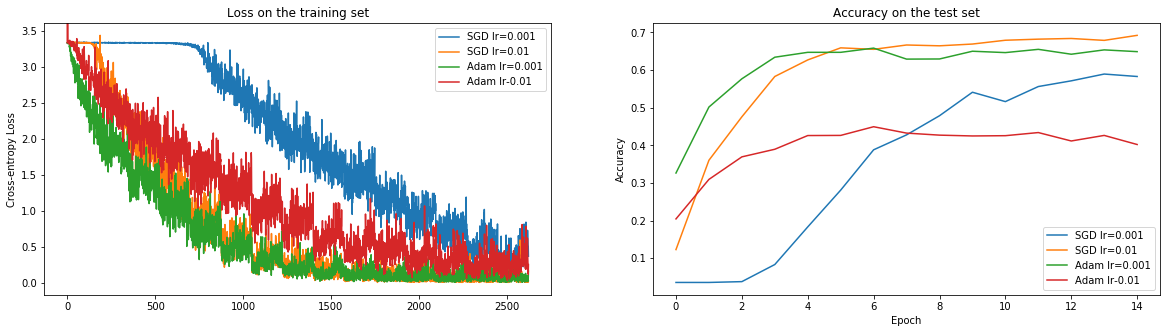

In [44]:
import matplotlib.pyplot as plt

train_loss = np.load('./GSN/results_without_batch_norm/train_loss.npy')
length = int(len(train_loss)/4)
_, ax = plt.subplots(1,2, figsize = (20,5))
ax[0].plot(train_loss[0:length], label = opt_names[0])
ax[0].plot(train_loss[length:2*length], label = opt_names[1])
ax[0].plot(train_loss[2*length:3*length], label = opt_names[2])
ax[0].plot(train_loss[3*length:4*length], label = opt_names[3], scaley = False)

ax[0].set_title('Loss on the training set')
ax[0].set_ylabel('Cross-entropy Loss')
ax[0].legend()

test_acc = np.load('./GSN/results_without_batch_norm/test_accuracy.npy')
length = int(len(test_acc)/4)
ax[1].plot(test_acc[0:length], label = opt_names[0])
ax[1].plot(test_acc[length:2*length], label = opt_names[1])
ax[1].plot(test_acc[2*length:3*length], label = opt_names[2])
ax[1].plot(test_acc[3*length:4*length], label = opt_names[3])
ax[1].set_title('Accuracy on the test set')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

### Training the network with batch normalization:
I trained six networks with optimizers: SGD with momentum and lr=0.001, 0.01, 0.1 and Adam with lr = lr=0.001, 0.01, 0.1. I wanted to check how this network behaves for bigger learning rates, because batch normalization is said to allow using bigger learning rates. But it turned out that the best is Adam with lr = 0.001.

In [ ]:
def weight_reset(m):
    if (isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or 
        isinstance(m, BatchNorm1D) or isinstance(m, BatchNorm2D)):
        m.reset_parameters()
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net_with_BatchNorm()
#net = Net_with_PyTorchBatchNorm()

criterion = nn.CrossEntropyLoss()
optimizers = [optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9),
              optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9),
              optim.SGD(net.parameters(), lr = 0.1, momentum = 0.9),
              optim.Adam(net.parameters(), lr = 0.001),
              optim.Adam(net.parameters(), lr = 0.01),
              optim.Adam(net.parameters(), lr = 0.1)]
opt_names = ['SGD lr=0.001',
             'SGD lr=0.01',
             'SGD lr=0.1',
             'Adam lr=0.001',
             'Adam lr=0.01',
             'Adam lr=0.1']

train_loss = []
test_loss = []
test_acc = []        
for i in range(6):
    net.apply(weight_reset)
    net.to(device)
    optimizer = optimizers[i]
    for epoch in range(15):
        for data in train_loader:  
            inputs, labels = data[0].to(device), data[1].to(device)
      
            optimizer.zero_grad()
      
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
      
            train_loss.append(loss.item())
        
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = net(images)
                loss = criterion(outputs, labels)
                test_loss.append(loss.item())     
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_acc.append(correct/total)
    PATH = '/results/pgrabysz/net with BatchNorm ' + opt_names[i] +'.pth'  
    torch.save(net.state_dict(), PATH)

import numpy as np
np.save('/results/pgrabysz/train_loss_BatchNorm.npy', train_loss)
np.save('/results/pgrabysz/test_loss_BatchNorm.npy', test_loss)
np.save('/results/pgrabysz/test_accuracy_BatchNorm.npy', test_acc)

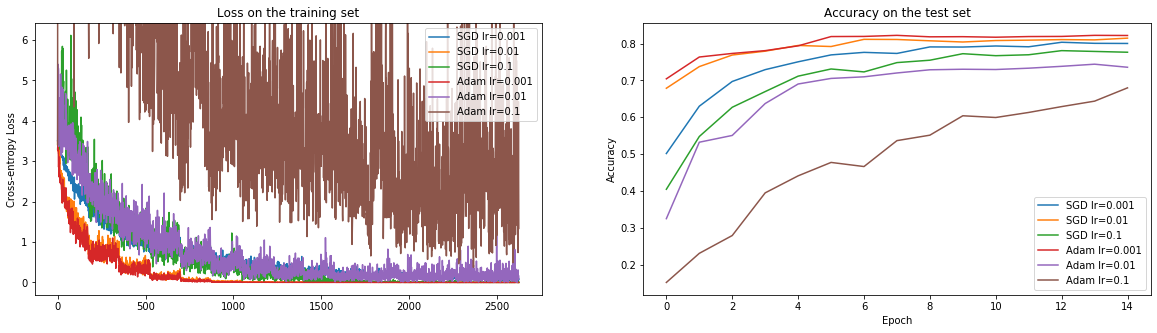

In [80]:
train_loss = np.load('./GSN/results_with_batch_norm/train_loss_BatchNorm.npy')
length = int(len(train_loss)/6)
_, ax = plt.subplots(1,2, figsize = (20,5))
ax[0].plot(train_loss[:length], label = opt_names[0])
ax[0].plot(train_loss[length:2*length], label = opt_names[1])
ax[0].plot(train_loss[2*length:3*length], label = opt_names[2])
ax[0].plot(train_loss[3*length:4*length], label = opt_names[3])
ax[0].plot(train_loss[4*length:5*length], label = opt_names[4])
ax[0].plot(train_loss[5*length:6*length], label = opt_names[5], scaley=False)

ax[0].set_title('Loss on the training set')
ax[0].set_ylabel('Cross-entropy Loss')
ax[0].legend()

test_acc = np.load('./GSN/results_with_batch_norm/test_accuracy_BatchNorm.npy')
length = int(len(test_acc)/6)
ax[1].plot(test_acc[:length], label = opt_names[0])
ax[1].plot(test_acc[length:2*length], label = opt_names[1])
ax[1].plot(test_acc[2*length:3*length], label = opt_names[2])
ax[1].plot(test_acc[3*length:4*length], label = opt_names[3])
ax[1].plot(test_acc[4*length:5*length], label = opt_names[4])
ax[1].plot(test_acc[5*length:6*length], label = opt_names[5])

ax[1].set_title('Accuracy on the test set')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

The problem I previously had with my batch normalization was that in the test_loader() I set shuffle = False and I put batch_size = 99, which is the size of a whole class in the test set. So batch norm calculated mean and standard deviation for every class separately, and this caused the problem.
I realised this when I looked on the plots of training loss and test accuracy. Training loss converged to zero very quickly, suggesting that the networs is optimizing the criterion properly. But the test accuracy was very poor, as it is on the picture below:

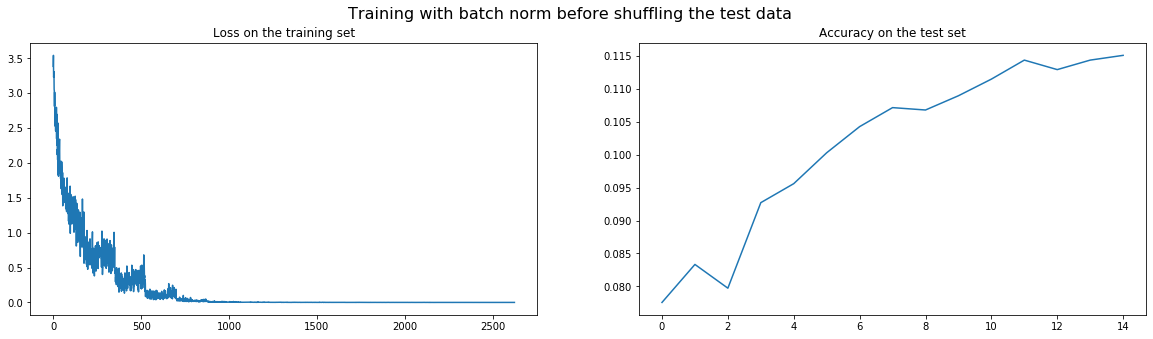

In [78]:
fig, ax = plt.subplots(1,2, figsize = (20,5))
fig.suptitle('Training with batch norm before shuffling the test data', fontsize = 16)
train_loss = np.load('./GSN/results_with_batch_norm/train_loss_CustomBN.npy')
ax[0].plot(train_loss)
ax[0].set_title('Loss on the training set')

test_acc = np.load('./GSN/results_with_batch_norm/test_accuracy_CustomBN.npy')
ax[1].plot(test_acc)
ax[1].set_title('Accuracy on the test set')
plt.show()

## Confusion matrix

Firstly, I reload the network with the highest accuracy, which is the one trained with batch normalization and Adam with lr=0.001

In [83]:
net = Net_with_BatchNorm()

PATH = './GSN/results_with_batch_norm/net with BatchNorm Adam lr=0.001.pth'
net.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [88]:
confusion_matrix = torch.zeros(28,28)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(28):
            tmp_idx = torch.where(predicted == i)
            for j in labels[tmp_idx]:
                confusion_matrix[i, j] = confusion_matrix[i, j] +  1

In [89]:
#Sanity check if confusion_matrix contains the same number of elements as test set
#There are 28 classes, each of them has 99 representatives in the test set
print(torch.sum(confusion_matrix) == 99*28) 

tensor(True)


In [90]:
print("Accuracy per class:")
for i in range(28):
    print("Accuracy of class {:} : {:.2f}%".format(i, 100 * confusion_matrix[i,i] / 99))

Accuracy per class:
Accuracy of class 0 : 80.81%
Accuracy of class 1 : 65.66%
Accuracy of class 2 : 77.78%
Accuracy of class 3 : 82.83%
Accuracy of class 4 : 85.86%
Accuracy of class 5 : 79.80%
Accuracy of class 6 : 85.86%
Accuracy of class 7 : 90.91%
Accuracy of class 8 : 81.82%
Accuracy of class 9 : 81.82%
Accuracy of class 10 : 83.84%
Accuracy of class 11 : 81.82%
Accuracy of class 12 : 78.79%
Accuracy of class 13 : 77.78%
Accuracy of class 14 : 71.72%
Accuracy of class 15 : 84.85%
Accuracy of class 16 : 90.91%
Accuracy of class 17 : 78.79%
Accuracy of class 18 : 81.82%
Accuracy of class 19 : 85.86%
Accuracy of class 20 : 84.85%
Accuracy of class 21 : 78.79%
Accuracy of class 22 : 86.87%
Accuracy of class 23 : 83.84%
Accuracy of class 24 : 78.79%
Accuracy of class 25 : 87.88%
Accuracy of class 26 : 80.81%
Accuracy of class 27 : 93.94%


The person we the lowest accuracy is the lady on the picture below. Her pictures in the test set might be difficult, because she sometimes has blond hair, sometimes black, and her hair is crazy in general. There is also quite a lot of black and white pictures (6 out of 99).
The person we the biggest accuracy is Sheldon. Indeed, almost all of his pictures looks really the same.

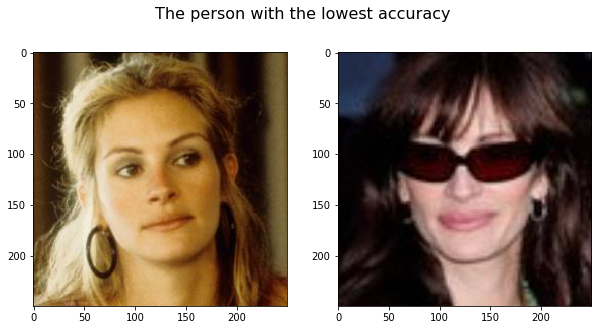

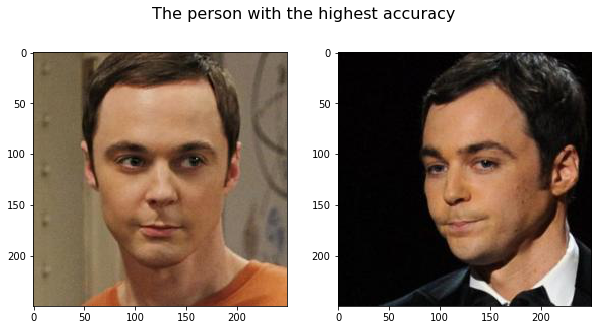

In [111]:
path = 'C:/Users/Piotr Grabysz/Documents/GSN data/projekt 1/test/'
fig, ax = plt.subplots(1,2, figsize = (10,5))
img1 = mpimg.imread(path + '0000210/028.jpg')
img2 = mpimg.imread(path + '0000210/055.jpg')
ax[0].imshow(img1)
ax[1].imshow(img2)
fig.suptitle('The person with the lowest accuracy',fontsize = 16)
plt.show()

fig, ax = plt.subplots(1,2, figsize = (10,5))
img1 = mpimg.imread(path + '1433588/006.jpg')
img2 = mpimg.imread(path + '1433588/008.jpg')
ax[0].imshow(img1)
ax[1].imshow(img2)
fig.suptitle('The person with the highest accuracy',fontsize = 16)
plt.show()

Below I print the whole confusion matrix. Element (i, j) means: predicted as a class i, in fact belonging to a class j. 

In [46]:
print(confusion_matrix)

tensor([[67.,  3.,  0.,  0.,  1.,  3.,  0.,  0.,  1.,  0.,  3.,  2.,  0.,  1.,
          3.,  0.,  0.,  5.,  1.,  0.,  0.,  4.,  0.,  3.,  3.,  0.,  2.,  2.],
        [ 1., 57.,  1.,  2.,  0.,  0.,  0.,  0.,  3.,  1.,  0.,  4.,  3.,  1.,
          5.,  0.,  0.,  2.,  0.,  2.,  2.,  0.,  1.,  5.,  2.,  0.,  0.,  0.],
        [ 0.,  1., 68.,  9.,  1.,  0.,  1.,  3.,  0.,  0.,  1.,  0.,  0.,  1.,
          2.,  1.,  3.,  2.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  2.,  1.],
        [ 3.,  0.,  5., 72.,  1.,  0.,  2.,  3.,  0.,  3.,  3.,  3.,  4.,  6.,
          3.,  0.,  1.,  0.,  2.,  0.,  3.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 1.,  3.,  4.,  1., 78.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  7.,
          1.,  1.,  3.,  0.,  0.,  2.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.],
        [ 1.,  1.,  0.,  0.,  0., 69.,  0.,  0.,  5.,  0.,  2.,  0.,  0.,  0.,
          4.,  2.,  0.,  1.,  0.,  4.,  1.,  0.,  0.,  2.,  2.,  2.,  1.,  0.],
        [ 0.,  0.,  1.,  4.,  3.,  1., 77.,  0

Since it is difficult to read by an eye, I list all the indexes where the network was mistaken more than 6 times. Then I show exemplary images from the most confused classes.

In [103]:
idx_with_biggest_error = []
for i in range(28):
    for j in range(28):
        if (confusion_matrix[i,j] >=6) and i!=j:
            idx_with_biggest_error.append((i,j))
print(idx_with_biggest_error)

[(3, 2), (3, 13), (15, 14), (17, 1)]


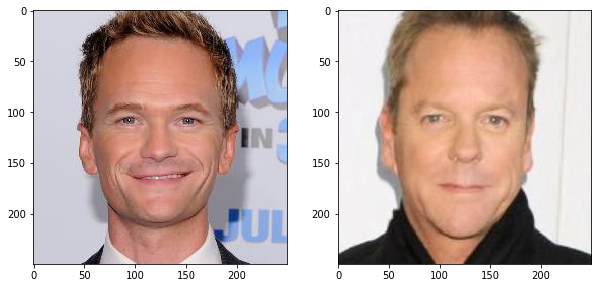

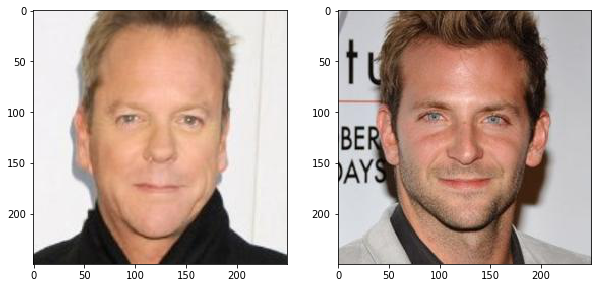

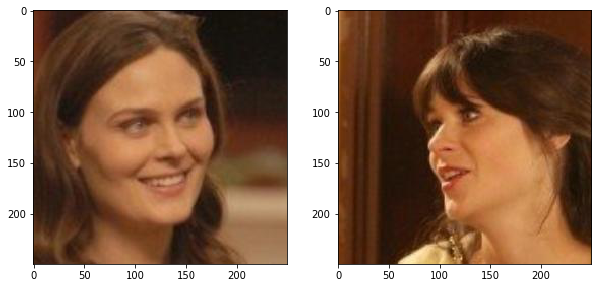

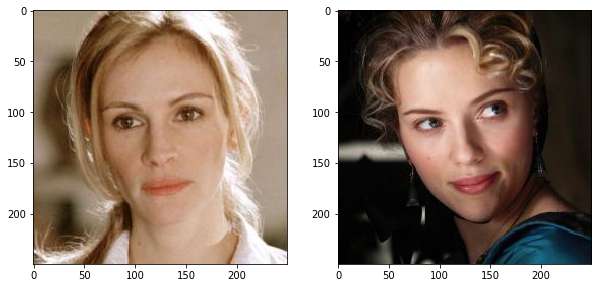

In [114]:
path = 'C:/Users/Piotr Grabysz/Documents/GSN data/projekt 1/test/'
img1 = mpimg.imread(path + '0000439/008.jpg')
img2 = mpimg.imread(path + '0000662/025.jpg')
_, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()

img1 = mpimg.imread(path + '0000662/025.jpg')
img2 = mpimg.imread(path + '0177896/029.jpg')
_, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()

img1 = mpimg.imread(path + '0221043/030.jpg')
img2 = mpimg.imread(path + '0221046/029.jpg')
_, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()

img1 = mpimg.imread(path + '0000210/014.jpg')
img2 = mpimg.imread(path + '0424060/033.jpg')
_, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()